# Homework 04:  More Tools for the Toolbox: Null Values, Categorical Features, and Cross Validation

In this homework, we are going to add three tools to your toolbox which will be essential when you work with real datasets:
1. What do we do with null-values?
2. How do we deal with non-numeric features?
3. What validation strategy provides the best estimate of the final testing score?

For (1), we'll explore several ways of dealing with null values:
- Removing columns with too many null values,
- Imputing values for missing categorical labels using the "most frequent" category strategy, and
- Imputing values for missing numeric values using the median. 


For (2), we'll use ordinal encoding to replace categorical labels with floats.

For (3), we'll try three different cross-validation strategies:

- 5-Fold CV,
- Repeated 5-Fold CV, and
- Leave One Out CV, 

and see which comes closest to estimating the final testing metric (RMSE and, optionally, $R^2$). 


#### Grading: There are eight (8) answers to provide, each worth 6 points.  (You get 2 points for free.)
 

In [1]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, LeaveOneOut
from sklearn.linear_model    import LinearRegression
from sklearn.preprocessing   import OrdinalEncoder, OneHotEncoder  
from sklearn.impute          import SimpleImputer
from sklearn.metrics         import mean_squared_error, r2_score
from tqdm                    import tqdm

random_seed = 42

d:\BU\Spring 2026\DX603 Module 3 - Machine Learning Fundamentals\HW Repo\Module-3-Assignments\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the Ames Housing Dataset

For a description of the features of this dataset, see the **Appendix**. 

In [2]:
# Download the latest version of the dataset
path = kagglehub.dataset_download("shashanknecrothapa/ames-housing-dataset")

print("Path to dataset files:", path)

# Construct the full path to the CSV file (update the file name if necessary)
csv_file = os.path.join(path, "AmesHousing.csv")

# Read the dataset into a DataFrame
df = pd.read_csv(csv_file)

Path to dataset files: C:\Users\jdhao\.cache\kagglehub\datasets\shashanknecrothapa\ames-housing-dataset\versions\1


In [3]:
# Print the first few rows of the DataFrame
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
# To see the listing of features

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   str    
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   str    
 7   Alley            198 non-null    str    
 8   Lot Shape        2930 non-null   str    
 9   Land Contour     2930 non-null   str    
 10  Utilities        2930 non-null   str    
 11  Lot Config       2930 non-null   str    
 12  Land Slope       2930 non-null   str    
 13  Neighborhood     2930 non-null   str    
 14  Condition 1      2930 non-null   str    
 15  Condition 2      2930 non-null   str    
 16  Bldg Type        2930 non-null   str    
 17  House Style      2930 non

Feature Histograms


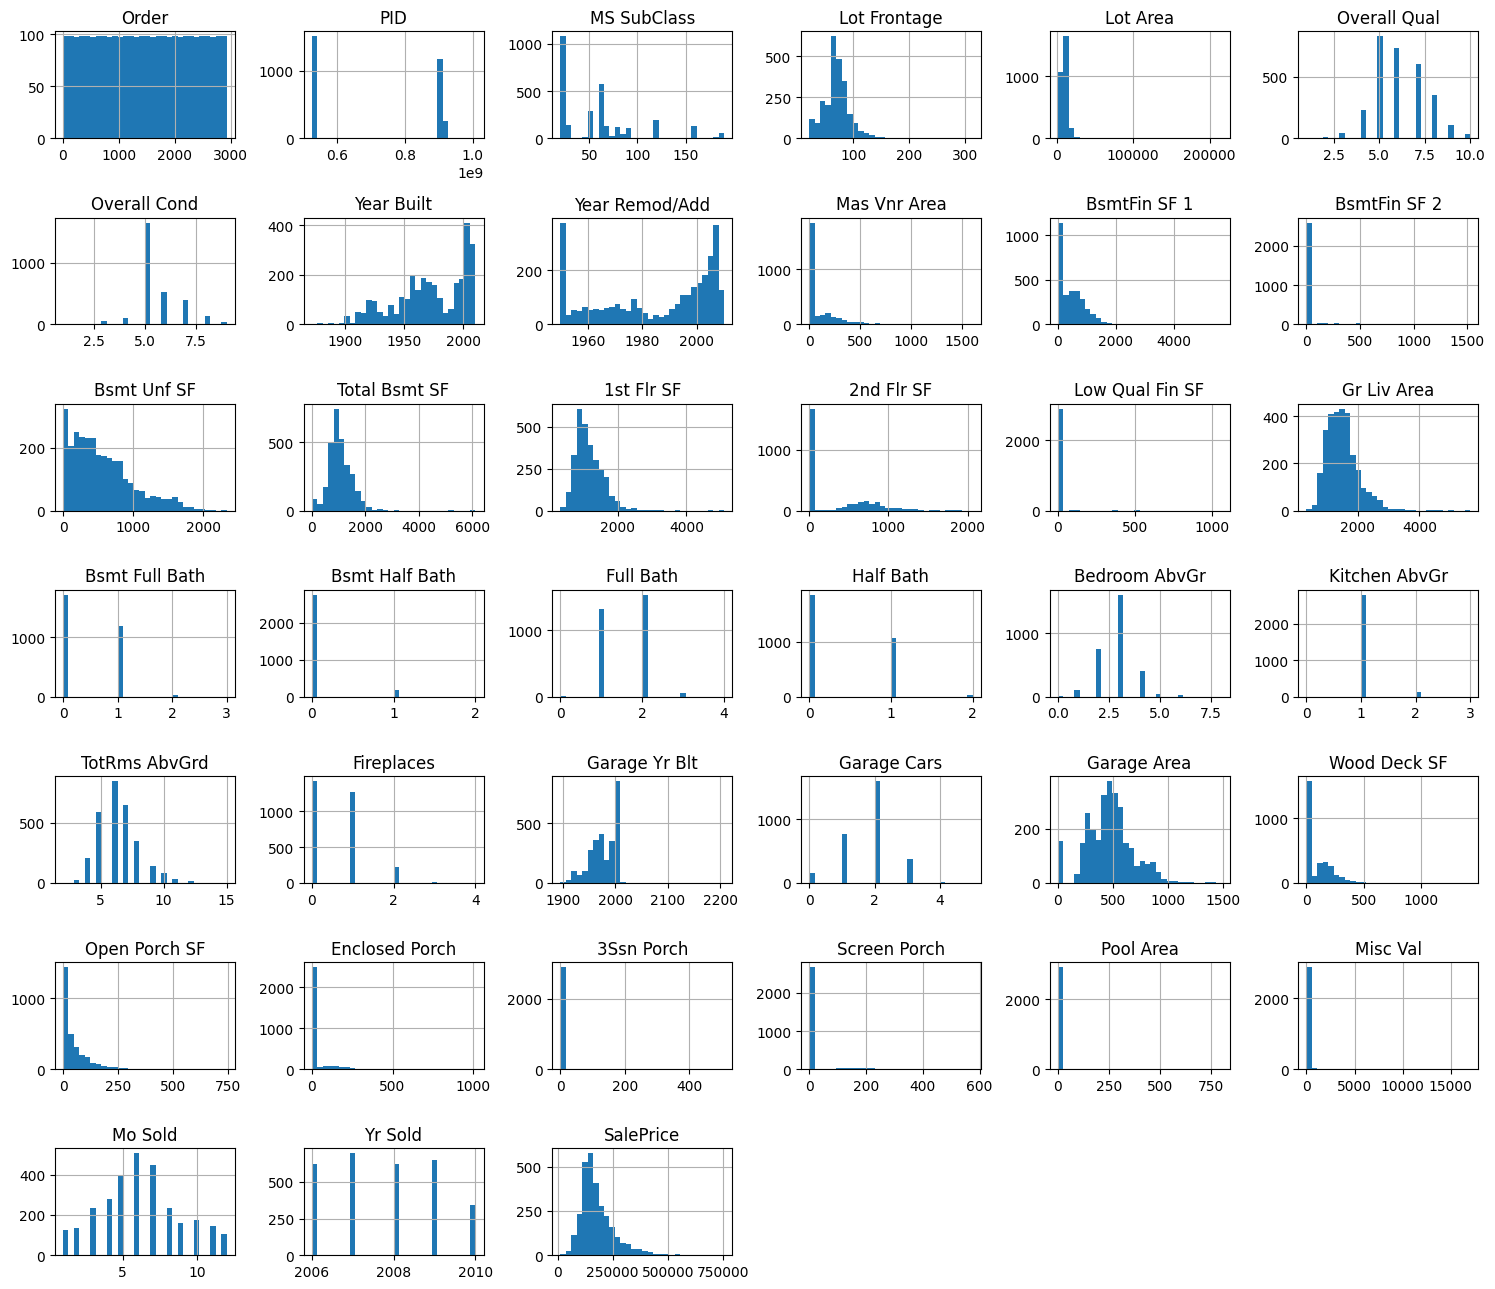

In [5]:
# To see the feature histograms

print("Feature Histograms")
df.hist(figsize=(15, 13), bins=30)  # Adjust figure size and number of bins
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

### Data Preprocessing

First, let's remove the features that are clearly not useful for regression: the row-number `Order` and the Parcel Identification Number `PID`.

In [6]:
df_clean = df.drop(columns=['Order','PID'])    # makes a copy
df_clean.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


### Problem One: Dealing with Null Values

There are basically two strategies for dealing with missing (null or `NaN`) values:
- Get them out of your dataset by **removing** features and/or samples containing too many nulls.
- **Impute** values by replacing nulls with the mean, median, or other "neutral" value computed from the feature.

**Note:** It is also possible to impute values using more advanced techniques such as mode imputation, forward/backward fill, or predictive modeling (e.g., KNN or regression-based imputation). These more advanced techniques might be useful when you start to work on your project. 

**First we will explore how many null values occur in each feature.**

In [7]:
# Although the info method above shows us which features have missing values and how many aren't missing,
# this function will provide more details about the missing values. 

# Fixed version of the function
from pandas.api.types import is_numeric_dtype

def show_null_counts_features(df):
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if is_numeric_dtype(x) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values, 
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)
    
    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name    # Nulls      Null %    Type')
        print('------------    -------      ------    ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<15} {row['# Null Values']:<12} {row['Null %']:.2f}%   {row['Type']}")


# Uncomment to see results
            
show_null_counts_features(df_clean)

The dataset contains 2930 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
Pool QC         2917         99.56%   Categorical
Misc Feature    2824         96.38%   Categorical
Alley           2732         93.24%   Categorical
Fence           2358         80.48%   Categorical
Mas Vnr Type    1775         60.58%   Categorical
Fireplace Qu    1422         48.53%   Categorical
Lot Frontage    490          16.72%   Numeric
Garage Qual     159          5.43%   Categorical
Garage Cond     159          5.43%   Categorical
Garage Yr Blt   159          5.43%   Numeric
Garage Finish   159          5.43%   Categorical
Garage Type     157          5.36%   Categorical
Bsmt Exposure   83           2.83%   Categorical
BsmtFin Type 2  81           2.76%   Categorical
Bsmt Cond       80           2.73%   Categorical
Bsmt Qual       80           2.73%   Categorical
BsmtFin Type 1  80           2.73%   Categorical
Mas Vnr Area    23           0.78%   Numeric

### Part A

Clearly, some of these features are not very informative! Let's drop the worst offenders!

**Fill in your code after the comments below to drop any features with more than `max_nulls` null values.**


In [8]:
max_nulls = 500      # we will drop any features with more than max_nulls missing values

# Count null values per column
null_val_per_col_counts = df_clean.isnull().sum()

# to check
print("Null Values per Column Counts:")
print(null_val_per_col_counts.sort_values(ascending=False))
print("--------------------------------------")
print("--------------------------------------")
# Filter out columns where null count exceeds max_nulls
columns_to_drop = null_val_per_col_counts[null_val_per_col_counts > max_nulls].index

# Drop the columns
df_clean = df_clean.drop(columns=columns_to_drop)

# Uncomment to verify they were removed
print(f"After dropping columns with more than {max_nulls} null values")
show_null_counts_features(df_clean)

Null Values per Column Counts:
Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Mas Vnr Type      1775
                  ... 
Mo Sold              0
Yr Sold              0
Sale Type            0
Sale Condition       0
SalePrice            0
Length: 80, dtype: int64
--------------------------------------
--------------------------------------
After dropping columns with more than 500 null values
The dataset contains 2930 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
Lot Frontage    490          16.72%   Numeric
Garage Finish   159          5.43%   Categorical
Garage Yr Blt   159          5.43%   Numeric
Garage Qual     159          5.43%   Categorical
Garage Cond     159          5.43%   Categorical
Garage Type     157          5.36%   Categorical
Bsmt Exposure   83           2.83%   Categorical
BsmtFin Type 2  81           2.76%   Categorical
Bsmt Qual       80           2.73%   Categorical
B

### Graded Question

Assign `a1a` to the number of features (columns) that were dropped

In [10]:
# Your answer here; use an expression, not a constant derived by examining the data

a1a = len(columns_to_drop)                     # replace 0 with an expression

In [11]:
# Do not change this cell in any way

print(f"a1a = {a1a}")                 

a1a = 6


### Part B:  Feature Transformations for Imputing Null Values

Now let's perform the following feature transformations:

- For categorical features, we'll replace null values with the most frequent category in that column
- For numeric features, we'll replace nulls with the median for that feature 


This is very simple to do with a couple of lines of Python, but naturally we want to use `sklearn` functions whenever we can, so we'll use ` SimpleImputer`.

**Go read the doc page for `SimpleImputer` before proceeding.**

### Imputing Categorical Features using the Most Frequent Strategy

In the next cell you see how easy it is to examine the categories. **Take a moment and explore several of the categorical features.**  In this dataset, most of them are skewed, with a clear "most favorite" category. 
(If the feature values are not skewed, then you could change these to a new category "Unknown".)

In [12]:
df_clean['Garage Qual'].value_counts(dropna=False)

Garage Qual
TA     2615
NaN     159
Fa      124
Gd       24
Po        5
Ex        3
Name: count, dtype: int64

Before proceeding, let's get lists of the two types of features.

In [13]:
# Identify categorical and numeric features

categorical_features = df_clean.select_dtypes(exclude=['number']).columns.tolist()
numeric_features     = df_clean.select_dtypes(include=['number']).columns.tolist()

# Uncomment to print results

print("Categorical Features:", categorical_features)
print()
print("Numeric Features:", numeric_features)

Categorical Features: ['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Sale Type', 'Sale Condition']

Numeric Features: ['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Ar

**Now you must impute all the categorical features using `SimpleImputer` with the `most_frequent` strategy.**

In [15]:
# First make a copy of the cleaned dataset
df_imputed = df_clean.copy()

# Impute categorical columns (using most frequent category)
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_imputed[categorical_features] = categorical_imputer.fit_transform(df_imputed[categorical_features])

# Verify: only numeric features should appear
print("After categorical imputation: No categorical features have missing values\n")
show_null_counts_features(df_imputed)

After categorical imputation: No categorical features have missing values

The dataset contains 2930 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
Lot Frontage    490          16.72%   Numeric
Garage Yr Blt   159          5.43%   Numeric
Mas Vnr Area    23           0.78%   Numeric
Bsmt Half Bath  2            0.07%   Numeric
Bsmt Full Bath  2            0.07%   Numeric
BsmtFin SF 1    1            0.03%   Numeric
BsmtFin SF 2    1            0.03%   Numeric
Total Bsmt SF   1            0.03%   Numeric
Bsmt Unf SF     1            0.03%   Numeric
Garage Cars     1            0.03%   Numeric
Garage Area     1            0.03%   Numeric


### Graded Question

Set `a1b` to the number of occurrences of the category `TA` in the feature `Garage Qual`. 
It should have increased from before the imputation, because `NaN` values were changed to `TA`

In [16]:
# Your answer here; use an expression, not a constant derived by examining the data

a1b = (df_imputed['Garage Qual'] == 'TA').sum()                        # replace 0 with an expression

In [17]:
# Do not change this cell in any way

print(f"a1b = {a1b}")                 

a1b = 2774


### Part C:  Imputing Numeric Features using the Median

Now you must "simply impute" values for the missing numeric features using the `median` strategy. 

In [18]:
# Impute numeric columns (using the median)
numeric_imputer = SimpleImputer(strategy='median')
df_imputed[numeric_features] = numeric_imputer.fit_transform(df_imputed[numeric_features])

# Verify: There should be no null values
print("After performing numeric imputation:\n")
show_null_counts_features(df_imputed)

After performing numeric imputation:

The dataset contains 2930 samples.

There are no null values in the dataset!


### Graded Question

Set `a1c` to the number of rows with missing values.  Use an expression, not a constant derived by examining the data.

In [19]:
# Your answer here; use an expression, not a constant derived by examining the data

a1c = df_imputed.isnull().any(axis=1).sum()                        # replace ... with an expression

In [20]:
# Do not change this cell in any way

print(f"a1c = {a1c}")                 

a1c = 0


### Part D:   Ordinal Encoding the categorical features with OrdinalEncoder

The simplest option in dealing with categorical values is to represent them by integers 0, 1, 2, etc.

**Before proceeding, read the doc page on `sklearn`'s `OrdinalEncoder`.**

> **Note on categorical encoding**
> We use OrdinalEncoder here as a simple, uniform approach to handling categorical variables. Some of these
> features are truly ordinal (e.g., quality and condition ratings), while others are nominal (no implied
> ordering among values). Ordinal encoding is not ideal for nominal variables, but it provides a compact
> baseline representation suitable for this assignment. We may need to consider alternative encodings
> later in the course.


Follow the comments to perform this feature transformation.

#### Note: Do not simply apply the `OrdinalEncoder` to the entire dataframe, as it will also encode the numeric features!
#### You can solve this using the same approach as the transformation in the previous problem. 

In [19]:
# Put df_imputed in the form X, y


# Initialize OrdinalEncoder

# Convert back to DataFrame to retain column names 


# # Verify: all Dtypes should be float64

# X.info()

### Graded Question

Set `a1d` to the number of categories imputed for `Lot Shape`. Hint: Just take the `len(...)` of the unique values in the newly-computed feature.

In [20]:
# Your answer here; use an expression, not a constant derived by examining the data

a1d = 0                         # replace 0 with an expression

In [21]:
# Do not change this cell in any way

print(f"a1d = {a1d}")                 

a1d = 0


## Problem Two:  Train and Test a Regression Model with Cross-Validation and Root Mean Square Errors

In this problem, we will perform a regression on the Ames Housing Dataset using several different cross-validation
strategies, comparing the cross-validation score for each with the final testing score, to see which provides the best
estimate of the final test score, and hence of the model's ability to generalize. 


We shall compare each of the following cross-validation RMSEs with the final test RMSE score:

- 5-Fold Cross-Validation (default)
- Repeated 5-Fold Cross-Validation (repeated 100 times)
- Leave-One-Out Cross Validation

> **Note:**
> `cross_val_score` always returns a score that is maximized.
> 
> For regression models, the default score is $R^2$, so values may be positive even though no error metric was specified.
> 
> For error metrics such as root mean squared error (RMSE), scikit-learn provides already-negated scorers (e.g., `scoring='neg_root_mean_squared_error'`).
These return −RMSE and must be negated to recover the RMSE on its original scale.
> 
> Be careful not to compare scores computed using different metrics (e.g., $R^2$ vs. RMSE).

### Part A: 5-Fold Cross-Validation

For this part
- Create a train-test split with `test_size=0.2` and `random_state=random_seed`
- Create a linear model and perform K-fold cross-validation with K = 5 and using `scoring='neg_root_mean_squared_error'` (remember to take the mean of the CV scores and negate the result, since results are negative). 
- Report the
    - CV score (negated mean of RMSE measurements over all K folds)
    - Test RMSE


Use `random_state = random_seed` for all experiments. 

In [22]:
# Your code here, add additional code cells if you wish


### Graded Question

Set `a2a` to the Test RMSE. 

In [23]:
# Your answer here; use an expression, not a constant derived by examining the data

a2a = 0                         # replace 0 with an expression

In [24]:
# Do not change this cell in any way

print(f"a2a = ${a2a:,.2f}")                 

a2a = $0.00


## Part B: Perform Repeated 5-Fold Cross Validation

Read the doc page on `sklearn`'s `RepeatedKFold` for cross validation; repeat the CV calculation with K = 5 and `n_repeats=100`
and report the CV score (negated mean of RMSE measurements over all 100*K folds)

In [25]:
# Your code here; add additional cells if you wish


### Graded Question

Set `a2b` to the mean CV score for the repeated K-fold experiment.

Note: if your CV score is negative, go back and read the instructions for Part A again

In [26]:
# Your answer here; use an expression, not a constant derived by examining the data

a2b = 0                        # replace 0 with an expression

In [27]:
# Do not change this cell in any way

print(f"a2b = ${a2b:,.2f}")                 

a2b = $0.00


## Part C: Perform Leave One Out Cross Validation

This is simply a matter of setting `cv=LeaveOneOut()`. Run the same experiment and report the CV score. 

**Note:** It may take 10 or more minutes to run.  Be patient (a good skill for an ML engineer to develop!). 

In [28]:
# Your code here; add additional cells if you wish


### Graded Question

Set `a2c` to the mean CV score for the leave-one-out experiment.


In [29]:
# Your answer here; use an expression, not a constant derived by examining the data

a2c = 0                        # replace 0 with an expression

In [30]:
# Do not change this cell in any way

print(f"a2c = ${a2c:,.2f}")                 

a2c = $0.00


### Part D: Which method gives the best estimate of generalization?

Different cross-validation strategies use the available data in different ways.
Although all of them aim to estimate how well a model will perform on unseen data,
their estimates can differ due to bias, variance, and how the data are split.

In this part, we compare the different cross-validation strategies to the held-out **test**
set to see which one provides the closest estimate of the model’s true
generalization performance.

### Graded Question

Set `a2d` to the **number** of the strategy whose cross-validation RMSE is closest (in absolute difference) to the Test RMSE, and hence potentially provides the best estimate of generalization performance.

Use:
- 1 = 5-fold CV
- 2 = Repeated 5-Fold CV
- 3 = Leave-One-Out CV

If two strategies are very close, you may choose either. 

In [31]:
# Your answer here

a2d = ...                       # Should be 1 = 5-fold CV; 2 = Repeated 5-Fold CV; or 3 = LOO CV  

In [32]:
# Do not change this cell in any way

print(f"a2d = {a2d}")                 

a2d = Ellipsis


### Optional Problem

Repeat the K-Fold and Repeated K-Fold experiments you just did in Problem 2, but use the $R^2$ metric (the default for `cross_validation_score` and does not need to be negated). (LOO can't use R2.) Did you get the same result for the last part (D)?

## Appendix: Explanation of Features in Ames Housing Dataset

### **Identification**
- `PID` → Parcel Identification Number (unique identifier for each property)
- `Order` → Row number (used for indexing, not a feature)

---

### **Sale Information**
- `SalePrice` → The final selling price of the house in USD (**Target variable**)
- `Mo Sold` → Month the house was sold (1 = January, ..., 12 = December)
- `Yr Sold` → Year the house was sold
- `Sale Type` → Type of sale (e.g., **WD** = Warranty Deed, **New** = Newly Built)
- `Sale Condition` → Condition of the sale (e.g., **Normal**, **Abnormal**, **Partial** for incomplete homes)

---

### **General Property Information**
- `MS SubClass` → Type of dwelling (e.g., **20 = 1-story**, **60 = 2-story**, **120 = Townhouse**)
- `MS Zoning` → Zoning classification (e.g., **RL = Residential Low Density**, **C = Commercial**)
- `Lot Frontage` → Linear feet of street connected to property
- `Lot Area` → Total size of the lot in square feet
- `Neighborhood` → Physical locations within Ames (e.g., **CollgCr = College Creek**)
- `Condition 1` / `Condition 2` → Proximity to roads or railroads (e.g., **Norm = Normal**, **PosN = Near Park**)

---

### **Building & House Design**
- `Bldg Type` → Type of dwelling (e.g., **1Fam = Single Family**, **Twnhs = Townhouse**)
- `House Style` → Style of the house (e.g., **1Story = One Story**, **2Story = Two Story**, **SplitFoyer**)
- `Overall Qual` → Overall quality of materials (scale: **1 = Very Poor** to **10 = Excellent**)
- `Overall Cond` → Overall condition of the house (scale: **1 = Very Poor** to **10 = Excellent**)

---

### **Year Built & Remodel**
- `Year Built` → Original construction year
- `Year Remod/Add` → Year of last remodel or addition

---

### **Exterior Features**
- `Exterior 1st` / `Exterior 2nd` → Exterior covering material (e.g., **VinylSd = Vinyl Siding**, **HdBoard = Hardboard**)
- `Mas Vnr Type` → Masonry veneer type (e.g., **BrkFace = Brick Face**, **None = No Veneer**)
- `Mas Vnr Area` → Area of masonry veneer in square feet

---

### **Basement Features**
- `Bsmt Qual` → Basement height (e.g., **Ex = Excellent**, **TA = Typical**, **Po = Poor**)
- `Bsmt Cond` → General condition of the basement
- `Bsmt Exposure` → Walkout or garden level basement?
- `BsmtFin Type 1` / `BsmtFin SF 1` → Primary finished area in basement (e.g., **GLQ = Good Living Quarters**)
- `BsmtFin Type 2` / `BsmtFin SF 2` → Secondary finished area
- `Bsmt Unf SF` → Unfinished square feet in basement
- `Total Bsmt SF` → Total square footage of basement

---

### **Utilities & HVAC**
- `Heating` → Type of heating system (e.g., **GasA = Gas Forced Air**, **OthW = Hot Water Heating**)
- `Heating QC` → Quality of heating system (e.g., **Ex = Excellent**, **Fa = Fair**)
- `Central Air` → **Y = Yes**, **N = No**
- `Electrical` → Electrical system (e.g., **SBrkr = Standard Breaker**, **FuseA = Fuse Box**)

---

### **Above Ground Living Area**
- `1st Flr SF` → First-floor square footage
- `2nd Flr SF` → Second-floor square footage
- `Gr Liv Area` → Total **above-ground** living area in square feet
- `Low Qual Fin SF` → Low-quality finished square feet (e.g., unfinished rooms)

---

### **Bathrooms & Bedrooms**
- `Full Bath` → Full bathrooms above ground
- `Half Bath` → Half bathrooms above ground
- `Bsmt Full Bath` → Full bathrooms in basement
- `Bsmt Half Bath` → Half bathrooms in basement
- `Bedroom AbvGr` → Number of bedrooms above ground
- `Kitchen AbvGr` → Number of kitchens above ground
- `Kitchen Qual` → Kitchen quality (**Ex = Excellent**, **Fa = Fair**)

---

### **Garage Features**
- `Garage Type` → Type of garage (e.g., **Attchd = Attached**, **Detchd = Detached**)
- `Garage Yr Blt` → Year garage was built
- `Garage Finish` → Interior finish of garage
- `Garage Cars` → Size of garage in car capacity
- `Garage Area` → Garage size in square feet

---

### **Additional Features**
- `Fireplaces` → Number of fireplaces
- `Fireplace Qu` → Fireplace quality
- `Paved Drive` → Paved driveway? (**Y = Yes, P = Partial, N = No**)
- `Wood Deck SF` → Square footage of wood deck
- `Open Porch SF` → Square footage of open porch
- `Enclosed Porch` → Square footage of enclosed porch
- `Screen Porch` → Square footage of screened porch
- `Pool Area` → Pool area in square feet
- `Misc Val` → Miscellaneous features (e.g., shed value)

